# networkinference tutorial

This tutorial explains some of the core functionality of the `networkinference` package and how it is intended to be used in practice. The package obviously heavily features the econometric work of the package author, who is in need of advertising due to his refusal to tweet. 

We will load data from a single network, estimate a linear-in-means model via TSLS, and construct dependence-robust confidence intervals with several different methods, each with different advantages and disadvantages. Inference with OLS or IPW estimators involves the same commands, other than the estimator class.

## Working with Python

For users new to Python, there are several options for executing Python commands. First, Stata17 users can call Python from [within Stata](https://www.stata.com/new-in-stata/pystata/). Second, one can install a Python IDE such as [PyCharm](https://www.jetbrains.com/pycharm/). Third, one can work in command line by typing 

    python3 

or execute Python commands saved in a `.py` file by typing 

    python3 my_python_script.py.

There are many tutorials available online for learning Python. A crash course put together for a Ph. D.-level economics class on networks can be found [here](https://github.com/mpleung/Python_tutorials).

## Load and format data

This part of the tutorial partly serves to illustrate some of the utilities in the `networkinference` package but mostly serves to explain how to get data into Python and into the right format for analysis.

We will load data from two files. The first is a csv containing outcome and covariate data for 1000 nodes in a single network. The second is an adjlist file that stores the network.

We use the `pandas` package to load csv data into an `R`-style dataframe object.

In [1]:
import pandas as pd
node_data = pd.read_csv('node_data.csv') # file assumed to be in this 
                                         # notebook's working directory

print(node_data.head(5))    # show first 5 rows of dataframe
print(node_data.describe()) # print summary statistics

          Y         X
0  8.304543  1.726436
1 -0.029856 -0.445788
2  1.312531  0.815567
3  2.271223 -0.544314
4 -1.367210 -1.678043
                 Y            X
count  1000.000000  1000.000000
mean      1.894746     0.002677
std       3.269896     0.983470
min      -9.054192    -3.158637
25%      -0.315210    -0.630493
50%       1.672337    -0.008020
75%       3.815592     0.619925
max      18.022742     3.138272


The first column above is the outcome, the second a scalar covariate. 

Next, we load the network data using the `networkx` package.

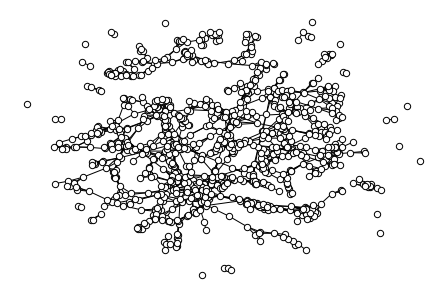

In [2]:
import networkx as nx
A = nx.read_adjlist('network.adjlist', nodetype=int) # load data

nx.draw(A, pos=nx.spring_layout(A, k=1/20, seed=0), node_size=40, \
        edgecolors='black', node_color='white')      # plot network

The `nodetype` argument ensures that node labels are read as integers rather than strings. Note: the package assumes nodes are labeled as integers 0, ..., n-1, where n is the network size. This way, the ith row of the data corresponds to node i.

The `core` class of `networkinference` includes a function that outputs a table of network summary statistics.

In [3]:
import networkinference as ni
ni.core.sumstats(A)

Summary Statistics
--------------------  --------
# Units               1000.000
# Links               2473.000
Average Degree           4.946
Max Degree              14.000
# Isolates              11.000
Giant Size             797.000
Diameter                67.000
Average Path Length     25.180
# Components            37.000
Clustering               0.578


The table indicates that we have a sparse network because the average degree is about 5, much smaller than the network size. The network is quite connected because there are few isolated nodes and the giant component contains a large share of nodes, a typical feature of social networks. The diameter and average path length are unusually large compared to typical social networks. Finally, the network exhibits high clustering (friends of friends tend to be friends), which is common.

We will estimate a linear-in-means model with three regressors: average outcomes of neighbors, average covariate of neighbors, and own covariate. We instrument for the first regressor using the average covariate of 2-neighbors (friends of friends).

To construct our regressor and instrument matrices, we first need to convert columns of our dataframe into arrays using the `numpy` package. `networkinference` requires node-level data to be provided as numpy arrays.

In [4]:
import numpy as np
Y = node_data['Y'].to_numpy() # array of outcomes
X = node_data['X'].to_numpy() # array of covariates

To construct vectors of average outcomes and covariates of neighbors and 2-neighbors, we can use a function in the `utils` subpackage of `networkinference`. 

In [5]:
import networkinference.utils as nu
nhbr_avg_Y = nu.nhbr_mean(Y, A)
nhbr_avg_X = nu.nhbr_mean(X, A)
two_nhbr_avg_X = nu.nhbr_mean(X, A, distance=2)

Finally, we construct the arrays of regressors and instruments. 

In [6]:
regressors = np.vstack([nhbr_avg_Y, nhbr_avg_X, X]).T
instruments = np.vstack([two_nhbr_avg_X, nhbr_avg_X, X]).T

pd.DataFrame(instruments, columns=['2 nhbr avg', 'nhbr avg', 'own']).describe() # just for printing summary statistics

,2 nhbr avg,nhbr avg,own
count,1000.000000,1000.000000,1000.000000
mean,-0.011524,-0.004285,0.002677
std,0.451400,0.504014,0.983470
min,-1.866928,-2.479348,-3.158637
25%,-0.260843,-0.309940,-0.630493
50%,-0.023416,-0.016504,-0.008020
75%,0.220878,0.267530,0.619925
max,2.235487,2.860034,3.138272


For those unfamiliar with `numpy` arrays, note that `nhbr_avg_Y` and the other arrays should be thought of as $1 \times n$ (i.e. horizontal) vectors. The above code stacks them vertically and then transposes the resulting matrix.

Thus, `regressors` is an $n \times 3$ matrix whose first column is the average outcomes of neighbors, and `instruments` is an $n \times 3$ matrix whose first column is the average covariate of 2-neighbors.

## Estimation

Next we load the data into a `TSLS` object and output the two-stage least squares estimate.

In [7]:
tsls = ni.TSLS(Y, regressors, instruments, A)
print(tsls.estimate)

[0.93397924 0.52239823 2.85116605 1.00725669]


Given how `regressors` and `instruments` were formatted, these entries correspond to the intercept, endogenous peer effect, exogenous peer effect, and own covariate coefficient.

As an aside, the `networkinference` package also includes an `OLS` class for the OLS estimator and an `IPW` class for the Horovitz-Thompson estimator. The methods discussed below are identical for all three classes.

## Network HAC SEs

We can call several different methods on the `tsls` object for constructing confidence intervals. The first uses a heteroskedasticity and network-autocorrelation consistent variance estimator due to [Kojevnikov et al. (2021)][3] with the bandwidth suggested by [Leung (2022a)][4].

In [8]:
tsls.network_se()

  Estimate     SE  95% CI
----------  -----  --------------
     0.934  0.105  [0.728, 1.14]
     0.522  0.046  [0.432, 0.612]
     2.851  0.152  [2.553, 3.149]
     1.007  0.055  [0.9, 1.115]


Network HAC SEs account for a general form of network dependence proposed by [Kojevnikov et al. (2021)][3] where correlation between two units decays with their network distance (measured by length of the shortest path). [Leung (2022a)][4] shows that this condition is satisfied in treatment effects models with interference and social interactions models such as linear-in-means.

## Cluster-robust inference

A common issue with HAC estimators is that, in smaller samples, they can produce CIs that are a bit too short. An alternative is to use cluster-robust inference methods, which appear to have better finite-sample performance [(Leung, 2022c)][6].

However, cluster-robust methods rely on the existence of "quality" clusters in the network. (We will quantify what's meant by "quality" shortly.) As we'll see below, this is not always guaranteed, as some networks may have no quality clusters. In contrast, HAC estimators are asymptotically valid irrespective of the existence of such clusters.

### Constructing clusters

In order to construct the clusters, we first have to figure out how many to ask for. [Leung (2022c)][6] shows that the eigenvalues of the normalized Laplacian of the network can be used to detect the number of "quality" clusters in the network. The `core` class provides functions for calculating and plotting the eigenvalues.

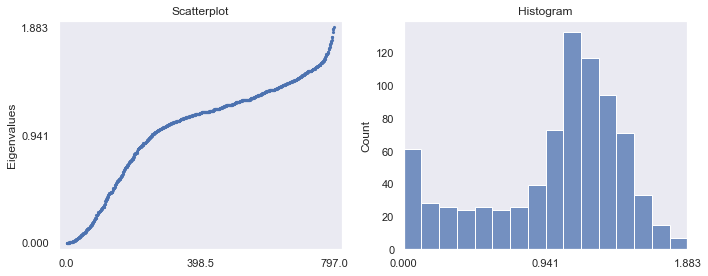

In [9]:
ni.core.plot_spectrum(A)

The number of eigenvalues near zero corresponds to the number of quality clusters, and we see a substantial number near zero in the histogram. (Strictly speaking, the function plots the spectrum of the giant component by default, so the plot shows the number of quality clusters in the giant.) The exercise here is similar to the use of screeplots to detect the number of principal components in PCA. 

The scatterplot is not as interesting, but we will see shortly below how it can be useful to see when quality clusters do *not* exist.

To get a better sense of how many eigenvalues are near zero, we compute how many are below 0.05.

In [10]:
eigenvals = ni.core.spectrum(A) # get vector of eigenvalues
print(f'{(eigenvals < 0.05).sum()} eigenvalues are below 0.05')

38 eigenvalues are below 0.05


This suggests there could be as many as 38 "quality" clusters in the network. To actually construct the clusters, we can use spectral clustering by calling the following method, which stores the result in the `tsls` object for later use.

In [11]:
tsls.get_clusters(38, seed=0)

Maximal conductance: 0.12727272727272726


**Maximal conductance** is the key $[0,1]$-measure of cluster quality. [Leung (2022c)][6] shows that for cluster-robust inference methods to work, this value must be near zero. In practice, he recommends that the value not exceed 0.1. With the current set of 38 clusters, we're a little over that threshold, so maybe we can try asking for a few less.

In [12]:
tsls.get_clusters(30, seed=0)

Maximal conductance: 0.08771929824561403


We now have 30 low-conductance clusters we can use to conduct inference. 

Before using them, let us take a digression and look at a cautionary tale showing that not all networks have quality (low-conductance) clusters. 

### When not to cluster

We draw a new network $G$ from an Erdos-Renyi model with the same average degree and size as $A$ and plot the spectrum.

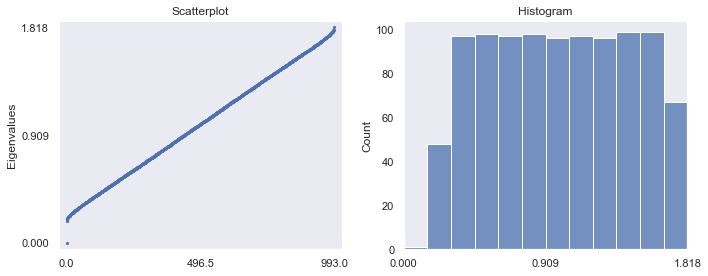

1 eigenvalues are below 0.18


In [13]:
n, avg_degree = 1000, 5
G = nx.fast_gnp_random_graph(n, avg_degree/n, seed=0)
ni.core.plot_spectrum(G)

eigenvals = ni.core.spectrum(G)
print(f'{(eigenvals < 0.18).sum()} eigenvalues are below 0.18')

The histogram shows only one eigenvalue near zero, while the scatterplot reveals a "spectral gap" between the first and second eigenvalues. Note that the first eigenvalue is always zero and uninteresting. The next largest eigenvalue is around 0.19, which is rather far from zero. This suggests there are no good clusters in this network. Indeed, if we implement spectral clustering and ask for a just 2 clusters, we already obtain a large maximal conductance. Asking for more will only result in a worse value.

In [14]:
for num_clusters in [2,6]:
  clusters = ni.core.spectral_clustering(num_clusters, G, seed=0)
     # alternate way of implementing spectral clustering without 
     # having to instantiate TSLS object
  print(f'Maximal conductance with {num_clusters} clusters:\
  {ni.core.conductance(clusters, G)}')

Maximal conductance with 2 clusters:  0.34775888717156106
Maximal conductance with 6 clusters:  0.5071283095723014


Due to the lack of quality clusters, using cluster-robust inference methods with the network $G$ can result in severe size distortion [(Leung 2022c)][6], so an alternative method should be used instead.

**Summary:** We can use `ni.core.plot_spectrum()` to assess the number of quality clusters in the network and then construct the clusters using the method `get_clusters()` of the `tsls` object.

### Clustered SEs

Returning to our original network $A$ with 30 quality clusters, we have two options for constructing confidence intervals. The first is conventional clustered standard errors. 

In [15]:
tsls.cluster_se()

  Estimate     SE  95% CI
----------  -----  --------------
     0.934  0.078  [0.781, 1.087]
     0.522  0.029  [0.466, 0.579]
     2.851  0.136  [2.585, 3.118]
     1.007  0.043  [0.923, 1.091]


Note that, after calling `get_clusters()`, the result is stored in the `tsls` object, and that result is subsequently used by the `cluster_se()` method.

### t-Statistic based test

What if we only have a very small number of quality clusters, say 8? Then we have two alternatives. The simplest is the t-statistic based procedure due to [Ibragimov and Mueller (2010)][2].

In [16]:
tsls.get_clusters(8)
tsls.trobust_ci()

Maximal conductance: 0.0374331550802139
  Estimate  CI
----------  --------------
     0.934  [0.721, 1.179]
     0.522  [0.355, 0.628]
     2.851  [2.386, 3.22]
     1.007  [0.85, 1.14]


### Approximate randomization test

A potentially more powerful but slightly more computationally demanding alternative is to use approximate randomization tests [(Canay et al., 2017)][1].

In [17]:
tsls.arand_ci(-4, 4)

  Estimate  CI
----------  --------------
     0.934  [0.747, 1.173]
     0.522  [0.373, 0.64]
     2.851  [2.347, 3.2]
     1.007  [0.853, 1.12]


These CIs are a bit narrower, indicating higher power. They are more computationally demanding because they are constructed by inverting a hypothesis test. The parameters -4 and 4 are the left and right endpoints of a grid, and a parameter `grid_size` controls how many grid points to potentially evaluate. 

Both the t-statistic and approximate randomization tests work by computing $L$ TSLS estimates separately across the $L$ clusters, so when using more clusters, the results can sometimes be more unstable since there's less data within each cluster. Here, though, we're only asking for 8 clusters, and the results are similar to clustered SEs.

## Dependence-robust test

The previous CIs use network data to account for network dependence, but in some situations, we may have insufficient knowledge of the dependence structure. The network data may be low quality with many missing or mismeasured links, or the analyst may be unsure about the type of dependence (network dependence? spatial dependence? cluster dependence? some combination of these?).

For these scenarios, we can resort to a resampling method due to [Song (2016)][7]. [Leung (2022b)][5] shows that this method works for regular estimators (like OLS, TSLS, IPW) whenever they are $\sqrt{n}$-consistent, a requirement satisfied by most forms of weakly dependent data. Since the method does not require knowledge of the dependence structure, it can be applied to time series data when time periods are unobserved, spatial data when spatial locations are unknown, or clustered data when cluster memberships are unknown. 

We compute dependence-robust CIs using the following method.

In [18]:
tsls.drobust_ci(-4, 4, seed=0)

  Estimate  CI
----------  -------------
     0.934  [0.16, 1.6]
     0.522  [0.16, 0.907]
     2.851  [1.333, 3.84]
     1.007  [0.64, 1.44]


This method does not use the network data supplied to the `tsls` object. For use with non-network data, we can invoke this method by instantiating the `tsls` object without supplying the network argument at all.

In [19]:
tsls_no_network = ni.TSLS(Y, regressors, instruments) # no network argument
tsls_no_network.drobust_ci(-4, 4, seed=0)  # same results

  Estimate  CI
----------  -------------
     0.934  [0.16, 1.6]
     0.522  [0.16, 0.907]
     2.851  [1.333, 3.84]
     1.007  [0.64, 1.44]


This method is the most computationally demanding because it resamples the data to construct test statistics and then constructs the CI via test inversion. It has two other important disadvantages.

1. It requires a larger amount of data to ensure adequate coverage and power. In particular, it is much less powerful than the other procedures, yielding wider CIs. Of course, since this is a method that relies on little prior knowledge about the dependence structure, it is unsurprising that it can deliver weaker conclusions.

2. The output is random, which is why we set the seed in the `drobust_ci()` method. However, the method contains a parameter `L`, the number of resampling draws, which can be made arbitrarily large to make the randomness of the output arbitrarily small. This only requires more computation time.

## Other methods

Invoke

    help(tsls)
    
for information on the other available methods, which are scalar equality dependence-robust and approximate randomization tests.

Finally, all of the methods discussed above are accessible as independent functions through the 'core' class for use with custom estimators. See

    help(ni.core)

## References

* [1]: Canay, I., J. Romano, and A. Shaikh, "Randomization Tests Under an Approximate Symmetry Assumption," *Econometrica*, 2017, 85 (3), 1013-1030.
* [2]: Ibragimov, R. and U. Mueller, "t-Statistic Based Correlation and Heterogeneity Robust Inference," *Journal of Business and Economic Statistics*, 2010, 28 (4), 453-468.
* [3]: Kojevnikov, D., V. Marmer, and K. Song, "Limit Theorems for Network Dependent Random Variables," *Journal of Econometrics*, 2021, 222 (2), 882-908.
* [4]: Leung, M. "Causal Inference Under Approximate Neighborhood Interference," *Econometrica*, 2022a, 90(1), 267-293.
* [5]: Leung, M. "Dependence-Robust Inference Using Resampled Statistics," *Journal of Applied Econometrics*, 2022b, 37(2), 270-285.
* [6]: Leung, M., "Network Cluster-Robust Inference," *arXiv preprint arXiv:2103.01470*, 2022c.
* [7]: Song, K. "Ordering-Free Inference from Locally Dependent Data," *UBC working paper*, 2016.
